# Imports 

In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import random
import librosa.display
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
#os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
##Keras

#import keras
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout,Average
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.sequence import pad_sequences

from keras.models import Model
#from keras.layers.conlutional import Conv1D
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
#from keras.models import Model, Sequential
#from keras.layers import Dense, Embedding, LSTM, Add,Average
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
#from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.utils import to_categorical

#from keras.models import Model, Sequential
from keras import optimizers
from keras.layers import Input, Conv1D, Conv2D,BatchNormalization, MaxPooling1D,MaxPooling2D, LSTM, Dense, Activation, Layer,Reshape,Concatenate

from keras.utils import to_categorical
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


from sklearn.model_selection import train_test_split 
from sklearn.svm import SVC
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

from sklearn import (manifold, datasets, decomposition, ensemble,
             discriminant_analysis, random_projection)

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

import matplotlib.patheffects as pe
from sklearn.manifold import TSNE 
import seaborn as sns


# Reading file list

In [2]:
files=os.listdir('E:/Audio_full/')
## Data sets
# - RAVDESS Both speech and song with 8 emotions 2364 files in total with 24 actors each
# - TESS 7 emotions 2800 files in total
# - SAVEE 4 Actors 480 files in total

In [3]:
#pip install seaborn

In [4]:
#conda activate tensorflow-gpu

In [5]:
#Feeling dataset of corresponding audio

feeling_list=[]
for item in files:
    if item[6:-16]=='01' or item[2]=='n' or item[-11:-4]=='neutral' or item[6:-16]=='02':
        feeling_list.append('neutral')
    #elif :
        #feeling_list.append('calm')
    elif item[6:-16]=='03' or item[2]=='h' or item[-9:-4]=='happy':
        feeling_list.append('happy')
    elif item[6:-16]=='04' or item[2:4]=='sa' or item[-7:-4]=='sad':
        feeling_list.append('sad')
    elif item[6:-16]=='05' or item[2]=='a' or item[-9:-4]=='angry':
        feeling_list.append('angry')
    elif item[6:-16]=='07' or item[2]=='d' or item[-11:-4]=='disgust':
        feeling_list.append('disgust')
    elif item[6:-16]=='06' or item[2]=='f'or item[-8:-4]=='fear':
        feeling_list.append('fear')
    elif item[6:-16]=='08' or item[2:4]=='su' or item[-6:-4]=='ps':
        feeling_list.append('surprised')

In [6]:
labels = pd.DataFrame(feeling_list,columns=['emotions'])
labels

,emotions
0,neutral
1,neutral
2,neutral
3,neutral
4,neutral
...,...
5639,fear
5640,happy
5641,neutral
5642,surprised


# Extracting data from audio

In [7]:
## Converting the audio to data using MFCC PART 1
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(files):
    X, sample_rate = librosa.load('E:/Audio_full/'+y, res_type='kaiser_fast')
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X,sr=sample_rate, n_mfcc=50).T,axis=0)
    feature = mfccs
    df.loc[bookmark] = [feature]
    bookmark=bookmark+1
df

,feature
0,"[-700.3989, 58.63021, -3.025852, 16.040241, 4...."
1,"[-653.169, 58.028076, -12.581207, 11.818786, -..."
2,"[-617.0523, 60.10337, -5.9842577, 13.886285, 1..."
3,"[-698.7211, 47.088486, -11.333614, 12.963088, ..."
4,"[-715.9226, 71.9768, 4.457525, 18.602499, 8.40..."
...,...
5639,"[-343.40387, 32.59755, -9.197987, 25.315773, 0..."
5640,"[-345.47714, 24.427338, -14.398651, 36.95299, ..."
5641,"[-416.72632, 71.14924, -1.1160216, 42.52479, -..."
5642,"[-374.82407, 46.681873, -12.381617, 18.139084,..."


In [8]:
df2=pd.DataFrame(df['feature'].values.tolist())
df2=df2.fillna(0)
df2

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-700.398926,58.630211,-3.025852,16.040241,4.248529,3.869935,-6.381716,-0.188635,-13.735005,-0.319724,...,-3.432791,-1.268412,-2.037442,-3.208719,-2.298195,-2.391170,-2.533661,-0.790085,-2.240257,-1.202297
1,-653.169006,58.028076,-12.581207,11.818786,-7.681562,-0.617142,-8.337758,-5.823570,-6.547592,1.458057,...,-0.561838,-0.344248,-0.597152,-2.483091,-2.482294,-1.513263,-0.206973,-2.042859,-2.453341,-2.000150
2,-617.052307,60.103371,-5.984258,13.886285,1.120427,0.511750,-14.841358,-4.016369,-5.575839,-6.309851,...,3.856137,2.830290,0.607302,-0.470186,0.242361,-0.506050,0.155130,1.041393,0.215989,0.503251
3,-698.721130,47.088486,-11.333614,12.963088,-8.005651,-1.252229,-10.009068,-9.434125,-10.318875,-0.864674,...,3.345852,-0.199447,0.761450,0.445034,0.017971,-0.074606,-0.224912,-1.751279,-0.997531,0.558003
4,-715.922607,71.976799,4.457525,18.602499,8.404046,3.621954,-1.974365,0.022672,-2.678083,4.232803,...,0.427559,0.132589,-1.459148,-2.129129,-1.101375,1.795965,2.756026,1.120542,1.270001,1.677747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5639,-343.403870,32.597549,-9.197987,25.315773,0.052862,0.853997,-11.733653,0.140329,-25.528193,4.334096,...,6.829886,1.623786,0.174217,-2.333187,0.229022,-2.646233,-0.123384,2.442371,1.630154,-2.707299
5640,-345.477142,24.427338,-14.398651,36.952991,-7.297604,1.008584,-15.700944,-10.525764,-6.183089,-6.078100,...,-1.621850,-5.776743,-3.046839,0.392119,0.650877,1.291245,0.535487,2.879143,0.849994,-6.130474
5641,-416.726318,71.149239,-1.116022,42.524792,-6.296183,2.258823,-6.628646,-7.701837,-10.190816,7.239936,...,7.608363,6.693035,-1.709971,-7.858405,-4.653687,2.703166,4.437060,-1.495853,-8.279791,-6.083230
5642,-374.824066,46.681873,-12.381617,18.139084,-22.662424,4.170814,-15.546303,-7.580999,-18.976576,6.013675,...,1.192490,1.591670,1.171150,0.643918,0.412878,-1.108500,1.322803,-0.409489,1.067348,-0.033086


In [9]:
#MEL spectogram part2
dfmelSp = pd.DataFrame(columns=['feature1'])
bookmark=0
for index,y in enumerate(files):
    X, sample_rate = librosa.load('E:/Audio_full/'+y,res_type='kaiser_fast')
    sample_rate = np.array(sample_rate)
    mel= np.mean(librosa.feature.melspectrogram(y=X,sr=sample_rate).T,axis=0)
    feature = mel
    dfmelSp.loc[bookmark] = [feature]
    bookmark=bookmark+1
dfmelSp

,feature1
0,"[1.3591023e-06, 5.603021e-05, 0.003625807, 0.0..."
1,"[1.2332691e-05, 5.2230745e-05, 0.00011250672, ..."
2,"[2.6729702e-05, 0.00019209618, 0.0007873292, 0..."
3,"[6.656757e-06, 9.897744e-06, 1.4620192e-05, 7...."
4,"[0.00011870869, 0.00011706894, 0.0011368697, 0..."
...,...
5639,"[0.088534385, 0.032074165, 0.01548406, 0.01437..."
5640,"[0.0037470474, 0.0011213432, 0.0011808255, 0.0..."
5641,"[0.009096331, 0.0084486315, 0.008483385, 0.009..."
5642,"[0.019076487, 0.001114162, 0.0003238535, 0.000..."


In [10]:
dfmelSp2=pd.DataFrame(dfmelSp['feature1'].values.tolist())
dfmelSp2=dfmelSp2.fillna(0)
dfmelSp2

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.000001,0.000056,0.003626,0.020956,0.031414,0.017692,0.003454,0.018618,0.024684,0.020465,...,0.000002,0.000002,0.000001,6.755617e-07,3.586787e-07,3.909842e-07,2.609652e-07,6.226127e-08,1.362780e-08,1.109996e-09
1,0.000012,0.000052,0.000113,0.000077,0.000056,0.000892,0.010611,0.067382,0.132326,0.016235,...,0.000013,0.000009,0.000007,3.351835e-06,2.065444e-06,5.446865e-07,2.222711e-07,7.489701e-08,1.204194e-08,1.612842e-09
2,0.000027,0.000192,0.000787,0.002619,0.005716,0.046933,0.067469,0.030527,0.016795,0.009505,...,0.000045,0.000035,0.000022,1.127173e-05,6.057411e-06,2.383926e-06,1.396174e-06,7.454358e-07,1.715608e-07,2.231222e-08
3,0.000007,0.000010,0.000015,0.000008,0.000015,0.003372,0.008763,0.014438,0.032546,0.021561,...,0.000031,0.000026,0.000020,7.791955e-06,5.814118e-06,1.717594e-06,7.783661e-07,1.526976e-07,2.095097e-08,2.928901e-09
4,0.000119,0.000117,0.001137,0.003581,0.013649,0.008650,0.001231,0.002388,0.004787,0.014026,...,0.000003,0.000002,0.000002,9.353384e-07,4.004243e-07,2.418668e-07,7.589256e-08,2.278530e-08,4.165693e-09,3.284917e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5639,0.088534,0.032074,0.015484,0.014378,0.005388,0.002551,0.009657,0.521248,2.002649,0.849206,...,0.004074,0.003433,0.003914,3.691630e-03,1.624443e-03,3.285170e-04,2.007679e-04,6.891089e-05,2.034424e-05,3.410880e-06
5640,0.003747,0.001121,0.001181,0.001105,0.000706,0.001211,0.266760,2.143342,3.968316,3.609105,...,0.005176,0.005318,0.003357,2.874391e-03,2.240580e-03,6.783053e-04,1.343765e-04,7.181308e-05,3.513732e-05,1.744838e-05
5641,0.009096,0.008449,0.008483,0.009777,0.008108,0.011599,2.562184,7.563576,0.340539,0.011818,...,0.001646,0.002988,0.003047,2.352791e-03,9.355015e-04,1.696493e-04,5.026917e-05,1.020348e-05,4.442834e-06,4.414226e-07
5642,0.019076,0.001114,0.000324,0.000266,0.000249,0.001760,0.104751,0.308540,0.358288,0.242882,...,0.001825,0.002067,0.002671,1.932580e-03,1.206304e-03,1.850308e-04,8.864246e-05,1.673799e-05,6.823322e-06,6.962310e-07


In [11]:
newdf=pd.concat([df2,labels,dfmelSp2],axis=1)
newdf['emotions']
newdf[49]

0         neutral
1         neutral
2         neutral
3         neutral
4         neutral
          ...    
5639         fear
5640        happy
5641      neutral
5642    surprised
5643          sad
Name: emotions, Length: 5644, dtype: object

,49,49
0,-1.202297,0.000644
1,-2.000150,0.005754
2,0.503251,0.003092
3,0.558003,0.000424
4,1.677747,0.000418
...,...,...
5639,-2.707299,2.584399
5640,-6.130474,0.004410
5641,-6.083230,0.001173
5642,-0.033086,0.035044


In [12]:
newdf=shuffle(newdf)
newdf.shape
newdf

(5644, 179)

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
2934,-516.271484,89.496376,10.942081,18.594208,11.394368,15.894057,-15.966775,-7.985917,-16.698395,8.568154,...,1.583109e-04,9.179388e-05,3.409902e-05,2.197552e-05,7.979637e-06,5.630444e-06,1.572156e-06,9.410813e-07,1.018885e-07,7.048958e-09
5092,-421.011536,84.189247,-4.238965,19.934015,-12.254382,22.651762,-15.970331,-18.597593,-5.892712,4.486172,...,1.580390e-03,1.707572e-03,2.286305e-03,1.013776e-03,2.570866e-04,8.162257e-05,4.062942e-05,8.996803e-06,2.389017e-06,3.958062e-07
5132,-393.137390,92.719513,25.600391,32.084618,-26.660448,20.568970,-5.576462,-9.100204,-3.936832,-4.462693,...,1.227667e-02,6.471573e-03,5.513883e-03,4.634631e-03,1.761305e-03,5.612095e-04,1.693562e-04,2.947681e-05,7.183844e-06,5.472702e-07
5514,-320.063263,30.718958,-12.482727,25.605608,-14.741167,-2.386833,-11.486323,-7.723516,-7.792277,-2.908232,...,9.008169e-03,9.077596e-03,1.180687e-02,1.031671e-02,3.978746e-03,1.501160e-03,4.602907e-04,2.143146e-04,5.515561e-05,1.457704e-05
3589,-460.802246,95.077873,15.690827,-3.876984,-13.515173,7.231619,-9.968220,8.154779,-21.848038,-0.831346,...,4.504227e-04,2.989312e-04,1.524720e-04,9.417460e-05,5.909810e-05,3.547129e-05,1.475684e-05,2.266888e-06,3.041372e-07,2.446868e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2866,-450.121277,91.174728,-2.483131,-4.826207,9.525000,11.181990,-16.455383,7.700346,-15.215946,8.949797,...,4.337441e-04,4.554524e-04,3.171697e-04,1.812075e-04,9.939132e-05,3.864473e-05,6.933349e-06,1.257958e-06,1.428717e-07,1.309194e-08
4342,-317.869873,47.290913,-2.629568,32.384701,-21.081026,-3.051915,-6.255428,-17.116098,-18.406116,2.192631,...,1.307016e-02,9.971187e-03,7.765703e-03,7.151300e-03,3.868127e-03,8.466062e-04,2.549439e-04,9.305239e-05,2.344022e-05,2.463460e-06
2792,-616.132751,131.150513,34.722900,32.919247,14.669708,-6.133548,-9.525028,-1.352378,-7.214126,-12.323979,...,1.841107e-08,1.163517e-08,7.135496e-09,5.008630e-09,3.687416e-09,2.927539e-09,2.493058e-09,2.239627e-09,2.180947e-09,2.131606e-09
2038,-568.169373,62.406044,-16.230755,15.627676,-3.722815,1.403572,-13.131192,-1.151881,-19.131901,0.353588,...,1.127100e-04,5.343123e-05,2.014210e-05,1.238558e-05,1.010373e-05,7.331073e-06,1.643934e-06,5.261060e-07,9.197340e-08,7.776748e-09


In [13]:
#newdf.to_csv(r'E:\Fusion.csv',index=True,header=True)
#Saving the data to csv to save time

In [73]:
y=newdf['emotions']
x=newdf.iloc[:,0:50]
x1=newdf.iloc[:,51:179]
x.shape,y.shape,x1.shape

((5644, 50), (5644,), (5644, 128))

# Model Training

In [72]:
# For MFCC
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.20,shuffle=False)
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

 For MFCC
 CNN

#model = Sequential()

#model.add(Conv1D(64, 5,padding='same',input_shape=(50,1)))
#model.add(Activation('relu'))
#model.add(Dropout(0.1))
#model.add(MaxPooling1D(pool_size=(4)))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.1))
#model.add(MaxPooling1D(pool_size=(4)))
#model.add(Conv1D(256, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.1))
#model.add(Flatten())
#model.add(Dense(7))
#model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=1e-07, decay=0.0)
#def model(inputs):
inputs=keras.Input(shape=(50,1))
conv1=Conv1D(64,kernel_size=13,padding='same')(inputs)
acti1=Dense(64,activation="relu")(conv1)
drop1=Dropout(0.1)(acti1)
maxPool1=MaxPooling1D(pool_size=(4))(drop1)
conv2=Conv1D(128,kernel_size=13,padding='same')(maxPool1)
acti2=Dense(128,activation="relu")(conv2)
drop2=Dropout(0.1)(acti2)
maxPool2=MaxPooling1D(pool_size=(4))(drop2)
conv3=Conv1D(256,kernel_size=4)(maxPool2)
acti3=Dense(256,activation="relu")(conv3)
drop3=Dropout(0.1)(acti3)
#flat=Flatten()(drop3)

flat=Flatten()(drop3)
acti4=Dense(7,activation="softmax")(flat)
#drop4=Dropout(0.1)(acti4)

#flat1=Flatten()(drop4)
#dens1=Dense(7)
#acti5=Dense(7,activation="softmax")(acti4)

model=Model(inputs=inputs,outputs=acti4)

In [87]:
opt = keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=1e-07, decay=0.0)
#def model(inputs):
inputs=keras.Input(shape=(50,1))
conv1=Conv1D(64,kernel_size=13,padding='same')(inputs)
acti1=Dense(64,activation="relu")(conv1)
drop1=Dropout(0.1)(acti1)
maxPool1=MaxPooling1D(pool_size=(4))(drop1)
conv2=Conv1D(128,kernel_size=13,padding='same')(maxPool1)
acti2=Dense(128,activation="relu")(conv2)
drop2=Dropout(0.1)(acti2)
maxPool2=MaxPooling1D(pool_size=(4))(drop2)
conv3=Conv1D(256,kernel_size=3)(maxPool2)
acti3=Dense(256,activation="relu")(conv3)
drop3=Dropout(0.1)(acti3)
flat=Flatten()(drop3)
acti4=Dense(7,activation="softmax")(flat)
#drop4=Dropout(0.1)(acti4)

#dens1=Dense(7)
#acti5=Dense(7,activation="softmax")(acti4)

model=Model(inputs=inputs,outputs=acti4)

In [88]:
model.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        [(None, 50, 1)]           0         
_________________________________________________________________
conv1d_95 (Conv1D)           (None, 50, 64)            896       
_________________________________________________________________
dense_98 (Dense)             (None, 50, 64)            4160      
_________________________________________________________________
dropout_81 (Dropout)         (None, 50, 64)            0         
_________________________________________________________________
max_pooling1d_57 (MaxPooling (None, 12, 64)            0         
_________________________________________________________________
conv1d_96 (Conv1D)           (None, 12, 128)           106624    
_________________________________________________________________
dense_99 (Dense)             (None, 12, 128)           165

In [89]:
model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

In [90]:
## Converting emotions to int values MFCC
y_traincnn=[]
for lab in y_train:
    if lab=='neutral':
        y_traincnn.append(0)
    #elif lab=='calm':
        #y_traincnn.append(2)
    elif lab=='happy':
        y_traincnn.append(1)
    elif lab=='sad':
        y_traincnn.append(2)
    elif lab=='angry':
        y_traincnn.append(3)
    elif lab=='fear':
        y_traincnn.append(4)
    elif lab=='disgust':
        y_traincnn.append(5)
    elif lab=='surprised':
        y_traincnn.append(6)
y_traincnn=np.asarray(y_traincnn)
y_testcnn=[]
for lab in y_test:
    if lab=='neutral':
        y_testcnn.append(0)
    #elif lab=='calm':
        #y_testcnn.append(2)
    elif lab=='happy':
        y_testcnn.append(1)
    elif lab=='sad':
        y_testcnn.append(2)
    elif lab=='angry':
        y_testcnn.append(3)
    elif lab=='fear':
        y_testcnn.append(4)
    elif lab=='disgust':
        y_testcnn.append(5)
    elif lab=='surprised':
        y_testcnn.append(6)
y_testcnn=np.asarray(y_testcnn)

In [91]:
## Start CNN MFCC
cnn=model.fit(x_traincnn, y_traincnn, batch_size=16, epochs=100, validation_data=(x_testcnn, y_testcnn))

Epoch 1/100
283/283 [==============================] - 3s 6ms/step - loss: 3.5842 - accuracy: 0.2014 - val_loss: 2.1202 - val_accuracy: 0.3375
Epoch 2/100
283/283 [==============================] - 1s 5ms/step - loss: 1.7589 - accuracy: 0.3628 - val_loss: 1.4585 - val_accuracy: 0.4632
Epoch 3/100
283/283 [==============================] - 1s 5ms/step - loss: 1.4956 - accuracy: 0.4569 - val_loss: 1.2200 - val_accuracy: 0.5669
Epoch 4/100
283/283 [==============================] - 1s 5ms/step - loss: 1.2972 - accuracy: 0.5231 - val_loss: 1.1406 - val_accuracy: 0.5988
Epoch 5/100
283/283 [==============================] - 2s 5ms/step - loss: 1.1551 - accuracy: 0.5774 - val_loss: 1.0695 - val_accuracy: 0.6041
Epoch 6/100
283/283 [==============================] - 1s 5ms/step - loss: 1.1042 - accuracy: 0.5991 - val_loss: 1.0221 - val_accuracy: 0.6377
Epoch 7/100
283/283 [==============================] - 1s 5ms/step - loss: 1.0217 - accuracy: 0.6117 - val_loss: 0.9146 - val_accuracy: 0.6652

Epoch 58/100
283/283 [==============================] - 1s 5ms/step - loss: 0.3735 - accuracy: 0.8622 - val_loss: 0.5230 - val_accuracy: 0.7936
Epoch 59/100
283/283 [==============================] - 1s 5ms/step - loss: 0.3627 - accuracy: 0.8628 - val_loss: 0.4769 - val_accuracy: 0.8299
Epoch 60/100
283/283 [==============================] - 2s 5ms/step - loss: 0.3701 - accuracy: 0.8600 - val_loss: 0.4761 - val_accuracy: 0.8202
Epoch 61/100
283/283 [==============================] - 1s 5ms/step - loss: 0.3764 - accuracy: 0.8690 - val_loss: 0.5040 - val_accuracy: 0.8051
Epoch 62/100
283/283 [==============================] - 1s 5ms/step - loss: 0.3688 - accuracy: 0.8657 - val_loss: 0.5227 - val_accuracy: 0.8007
Epoch 63/100
283/283 [==============================] - 1s 5ms/step - loss: 0.3519 - accuracy: 0.8677 - val_loss: 0.4815 - val_accuracy: 0.8131
Epoch 64/100
283/283 [==============================] - 1s 5ms/step - loss: 0.3482 - accuracy: 0.8753 - val_loss: 0.4659 - val_accuracy:

Text(0.5, 1.0, 'loss per epoch')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

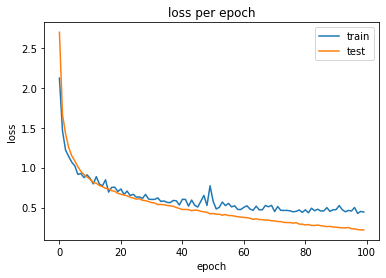

In [92]:
plt.plot(cnn.history['val_loss'])
plt.plot(cnn.history['loss'])
plt.title('loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Text(0.5, 1.0, 'accuracy per epoch')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epoch')

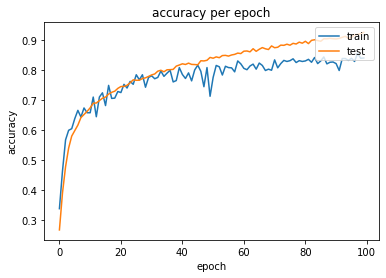

In [93]:
plt.plot(cnn.history['val_accuracy'])
plt.plot(cnn.history['accuracy'])
plt.title('accuracy per epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [94]:
predictions = model.predict(x_testcnn)
predictions
#np.argmax(model.predict(x_testcnn),axis=-1)

array([[1.34421904e-10, 2.20240189e-12, 1.45165685e-11, ...,
        1.00000000e+00, 2.22539998e-18, 2.21545194e-14],
       [9.69994128e-01, 2.99589094e-02, 3.87186046e-05, ...,
        7.88421676e-06, 3.89061098e-13, 7.50882429e-13],
       [9.97299492e-01, 2.69736815e-03, 1.76951028e-06, ...,
        1.64159943e-07, 2.33238203e-11, 1.98776474e-14],
       ...,
       [8.62322628e-01, 2.40973732e-03, 4.87987883e-03, ...,
        1.50498538e-03, 1.25989169e-01, 1.47167954e-03],
       [8.13375285e-04, 1.99440513e-02, 5.85877486e-02, ...,
        4.56311494e-01, 2.30343358e-05, 1.93033588e-06],
       [2.81950436e-03, 8.35432456e-06, 9.46188569e-01, ...,
        5.09799346e-02, 1.72311900e-07, 4.58906496e-10]], dtype=float32)

In [95]:
y_testcnn
y_traincnn

array([4, 0, 0, ..., 0, 3, 2])

array([2, 5, 2, ..., 0, 0, 4])

In [96]:
#from sklearn.metrics import classification_report
#report = classification_report(y_testcnn, predictions)
#print(report)
# 0 = neutral,1 = happy, 2 = sad, 3 = angry, 4 = fear, 5 = digust, 6 = surprised,

In [97]:
loss, acc = model.evaluate(x_testcnn, y_testcnn)
print("model, accuracy: {:5.2f}%".format(100*acc))

36/36 [==============================] - 0s 2ms/step - loss: 0.4445 - accuracy: 0.8397
model, accuracy: 83.97%


In [98]:
from sklearn.manifold import TSNE
tsne = TSNE(learning_rate=200.0, n_iter=2000,perplexity=25.0)

In [99]:
tsne_MFfeatures=tsne.fit_transform(model.predict(x))
tsne_MFfeatures.shape
tsne_MFfeatures[:,0]

(5644, 2)

array([ -3.7530823, -26.84126  ,  -6.0565124, ..., -66.81458  ,
        34.24012  , -33.09541  ], dtype=float32)

<AxesSubplot:>

<function matplotlib.pyplot.show(close=None, block=None)>

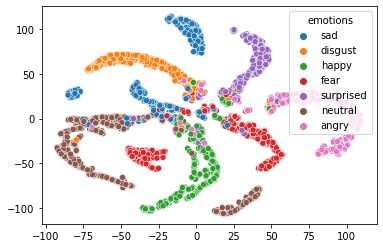

In [100]:
sns.scatterplot(x=tsne_MFfeatures[:,0],y=tsne_MFfeatures[:,1],hue=y,data=model.predict(x))
plt.show

# Saving model

In [ ]:
#model.save('E:/testingMFCC_model.h5')
#print("CNN MFCC MODEL SAVED")

In [35]:
from keras import backend as K

outputLayer=model.layers[13].output
model.predict(x_traincnn).round(1)

array([[0. , 0. , 1. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 1. , 0. ],
       [0. , 0. , 1. , ..., 0. , 0. , 0. ],
       ...,
       [1. , 0. , 0. , ..., 0. , 0. , 0. ],
       [1. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0.2, 0. , 0. , ..., 0.7, 0. , 0. ]], dtype=float32)

## MEL model training

In [36]:
## MEL CNN PART STARTS
Xmel_train, Xmel_test, ymel_train, ymel_test = train_test_split(x1,y, test_size = 0.20,shuffle=False)
xmel_traincnn = np.expand_dims(Xmel_train, axis=2)
xmel_testcnn = np.expand_dims(Xmel_test, axis=2)

##################### To be modified with

#newdf1 = np.random.rand(len(rnewdf)) < 0.8
#train = rnewdf[newdf1]
#test = rnewdf[~newdf1]

In [63]:
## MEL CNN model
#modelMel = Sequential()

#modelMel.add(Conv1D(64, 5,padding='same',input_shape=(128,1)))
#modelMel.add(Activation('relu'))
#modelMel.add(Dropout(0.1))
#modelMel.add(MaxPooling1D(pool_size=(4)))
#modelMel.add(Conv1D(128, 5,padding='same',))
#modelMel.add(Activation('relu'))
#modelMel.add(Dropout(0.1))
#modelMel.add(MaxPooling1D(pool_size=(4)))
#modelMel.add(Conv1D(256, 5,padding='same',))
#modelMel.add(Activation('relu'))
#modelMel.add(Dropout(0.1))
#modelMel.add(Flatten())
#modelMel.add(Dense(7))
#modelMel.add(Activation('softmax'))


In [ ]:
opt = keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=1e-07, decay=0.0)

inputs=keras.Input(shape=(128,1))
conv1=Conv1D(64,kernel_size=13,padding='same')(inputs)
acti1=Dense(64,activation="relu")(conv1)
drop1=Dropout(0.1)(acti1)
maxPool1=MaxPooling1D(pool_size=(4))(drop1)
conv2=Conv1D(128,kernel_size=13,padding='same')(maxPool1)
acti2=Dense(128,activation="relu")(conv2)
drop2=Dropout(0.1)(acti2)
maxPool2=MaxPooling1D(pool_size=(4))(drop2)
conv3=Conv1D(256,kernel_size=7)(maxPool2)
acti3=Dense(256,activation="relu")(conv3)
drop3=Dropout(0.1)(acti3)

flat=Flatten()(drop3)
acti4=Dense(7,activation="softmax")(flat)

modelMel=Model(inputs=inputs,outputs=acti4)

In [64]:
modelMel.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

In [65]:
ymel_traincnn=[]
for lab in ymel_train:
    if lab=='neutral':
        ymel_traincnn.append(0)
    #elif lab=='calm':
        #y_traincnn.append(2)
    elif lab=='happy':
        ymel_traincnn.append(1)
    elif lab=='sad':
        ymel_traincnn.append(2)
    elif lab=='angry':
        ymel_traincnn.append(3)
    elif lab=='fear':
        ymel_traincnn.append(4)
    elif lab=='disgust':
        ymel_traincnn.append(5)
    elif lab=='surprised':
        ymel_traincnn.append(6)
ymel_traincnn=np.asarray(ymel_traincnn)
ymel_testcnn=[]
for lab in ymel_test:
    if lab=='neutral':
        ymel_testcnn.append(0)
    #elif lab=='calm':
        #y_testcnn.append(2)
    elif lab=='happy':
        ymel_testcnn.append(1)
    elif lab=='sad':
        ymel_testcnn.append(2)
    elif lab=='angry':
        ymel_testcnn.append(3)
    elif lab=='fear':
        ymel_testcnn.append(4)
    elif lab=='disgust':
        ymel_testcnn.append(5)
    elif lab=='surprised':
        ymel_testcnn.append(6)
ymel_testcnn=np.asarray(ymel_testcnn)

In [66]:
## Start CNN
cnn1=modelMel.fit(xmel_traincnn, ymel_traincnn, batch_size=16, epochs=100, validation_data=(xmel_testcnn, ymel_testcnn))

Epoch 1/100
283/283 [==============================] - 4s 10ms/step - loss: 1.9629 - accuracy: 0.2259 - val_loss: 1.8638 - val_accuracy: 0.3277
Epoch 2/100
283/283 [==============================] - 3s 9ms/step - loss: 1.8263 - accuracy: 0.3367 - val_loss: 1.6880 - val_accuracy: 0.4101
Epoch 3/100
283/283 [==============================] - 3s 9ms/step - loss: 1.6987 - accuracy: 0.3741 - val_loss: 1.6210 - val_accuracy: 0.4278
Epoch 4/100
283/283 [==============================] - 3s 9ms/step - loss: 1.6562 - accuracy: 0.3815 - val_loss: 1.5733 - val_accuracy: 0.4455
Epoch 5/100
283/283 [==============================] - 3s 10ms/step - loss: 1.5602 - accuracy: 0.4378 - val_loss: 1.5474 - val_accuracy: 0.5004
Epoch 6/100
283/283 [==============================] - 3s 9ms/step - loss: 1.4665 - accuracy: 0.4974 - val_loss: 1.4538 - val_accuracy: 0.5155
Epoch 7/100
283/283 [==============================] - 3s 9ms/step - loss: 1.4215 - accuracy: 0.5172 - val_loss: 1.3609 - val_accuracy: 0.53

Epoch 58/100
283/283 [==============================] - 3s 9ms/step - loss: 0.7566 - accuracy: 0.7307 - val_loss: 1.0137 - val_accuracy: 0.6926
Epoch 59/100
283/283 [==============================] - 3s 10ms/step - loss: 0.7506 - accuracy: 0.7327 - val_loss: 0.9760 - val_accuracy: 0.6980
Epoch 60/100
283/283 [==============================] - 3s 9ms/step - loss: 0.7265 - accuracy: 0.7399 - val_loss: 1.0521 - val_accuracy: 0.6802
Epoch 61/100
283/283 [==============================] - 3s 9ms/step - loss: 0.7279 - accuracy: 0.7364 - val_loss: 0.9825 - val_accuracy: 0.7042
Epoch 62/100
283/283 [==============================] - 3s 9ms/step - loss: 0.7156 - accuracy: 0.7331 - val_loss: 1.0431 - val_accuracy: 0.6758
Epoch 63/100
283/283 [==============================] - 3s 9ms/step - loss: 0.7144 - accuracy: 0.7390 - val_loss: 1.0247 - val_accuracy: 0.7201
Epoch 64/100
283/283 [==============================] - 3s 10ms/step - loss: 0.7274 - accuracy: 0.7397 - val_loss: 0.9298 - val_accurac

Text(0.5, 1.0, 'loss vs epoch')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

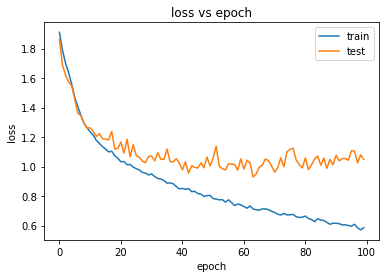

In [101]:
plt.plot(cnn1.history['loss'])
plt.plot(cnn1.history['val_loss'])
plt.title('loss vs epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Text(0.5, 1.0, 'model vs epoch')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epoch')

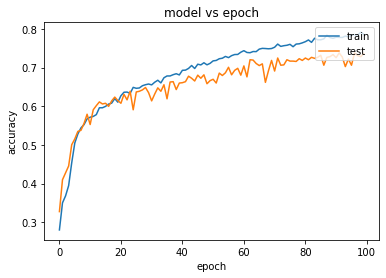

In [102]:
plt.plot(cnn1.history['accuracy'])
plt.plot(cnn1.history['val_accuracy'])
plt.title('model vs epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [103]:
Melpredictions = modelMel.predict(xmel_testcnn)
Melpredictions.shape
#np.argmax(modelMel.predict(xmel_testcnn),axis=-1)

(1129, 7)

In [104]:
ymel_testcnn

array([4, 0, 0, ..., 0, 3, 2])

In [105]:
modelMel.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 128, 1)]          0         
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 128, 64)           896       
_________________________________________________________________
dense_46 (Dense)             (None, 128, 64)           4160      
_________________________________________________________________
dropout_37 (Dropout)         (None, 128, 64)           0         
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 32, 64)            0         
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 32, 128)           106624    
_________________________________________________________________
dense_47 (Dense)             (None, 32, 128)           1651

In [106]:
tsne_Melfeatures=tsne.fit_transform(modelMel.predict(x1))
tsne_Melfeatures.shape
tsne_Melfeatures[:,0]

(5644, 2)

array([ 50.06265  , -58.58679  ,  68.85864  , ...,   7.6774173,
        -2.011658 ,  36.657352 ], dtype=float32)

<AxesSubplot:>

<function matplotlib.pyplot.show(close=None, block=None)>

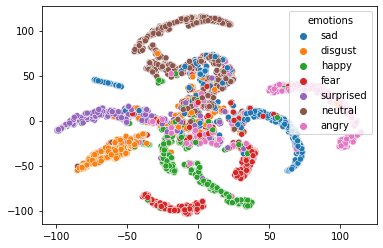

In [107]:
sns.scatterplot(x=tsne_Melfeatures[:,0],y=tsne_Melfeatures[:,1],hue=y,data=modelMel.predict(x1))
plt.show

In [ ]:
from sklearn.metrics import classification_report
#report = classification_report(ymel_testcnn, Melpredictions)
#print(report)
# 0 = neutral,1 = happy, 2 = sad, 3 = angry, 4 = fear, 5 = digust, 6 = surprised,

In [108]:
loss, acc = modelMel.evaluate(xmel_testcnn, ymel_testcnn)
print("model, accuracy: {:5.2f}%".format(100*acc))

36/36 [==============================] - 0s 4ms/step - loss: 1.0477 - accuracy: 0.7360
model, accuracy: 73.60%


In [109]:
from keras import backend as K

#MeloutputLayer=modelMel.layers[13].output
modelMel.predict(xmel_testcnn).round(1)
modelMel.predict(xmel_testcnn).shape

array([[0. , 0. , 0. , ..., 1. , 0. , 0. ],
       [0.3, 0.1, 0.3, ..., 0.2, 0. , 0. ],
       [0.6, 0.1, 0.1, ..., 0.2, 0. , 0. ],
       ...,
       [0.1, 0.1, 0.2, ..., 0.2, 0.1, 0.1],
       [0.1, 0.2, 0.1, ..., 0.2, 0.1, 0. ],
       [0.2, 0. , 0.6, ..., 0.2, 0. , 0. ]], dtype=float32)

(1129, 7)

In [ ]:
#from keras import backend as K

#outputLayer=model.layers[13].output
#model.predict(x_testcnn).round(1)
#model.predict(x_testcnn).round(1).shape

In [ ]:
#modelMel.save('E:/testingMel_model.h5')

In [110]:
#Fusion
mfccinp=keras.Input(shape=(None, 7))
melinp=keras.Input(shape=(None, 7))
fusion = Concatenate()([mfccinp, melinp])
#fuseOut=Average()(fusion)
fuseOut=Dense(7,activation="softmax")(fusion)
fuseF=Flatten()(fuseOut)

#model.output
#modelMel.output

In [111]:
fusionModel= Model(inputs=[mfccinp,melinp], outputs=fuseF)

In [112]:
fusionModel.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
predictions.shape
Melpredictions.shape
y_testcnn.shape

(1129, 7)

(1129, 7)

(1129,)

In [113]:
fusionLayer=fusionModel.fit([model.predict(x_traincnn),modelMel.predict(xmel_traincnn)],np.array(y_traincnn),batch_size=16,epochs=500,validation_data=([model.predict(x_testcnn),modelMel.predict(xmel_testcnn)], ymel_testcnn))

Epoch 1/500
283/283 [==============================] - 1s 1ms/step - loss: 1.9306 - accuracy: 0.1368 - val_loss: 1.9111 - val_accuracy: 0.1550
Epoch 2/500
283/283 [==============================] - 0s 755us/step - loss: 1.8976 - accuracy: 0.1447 - val_loss: 1.8849 - val_accuracy: 0.1585
Epoch 3/500
283/283 [==============================] - 0s 756us/step - loss: 1.8648 - accuracy: 0.1565 - val_loss: 1.8590 - val_accuracy: 0.1763
Epoch 4/500
283/283 [==============================] - 0s 770us/step - loss: 1.8334 - accuracy: 0.1985 - val_loss: 1.8333 - val_accuracy: 0.2046
Epoch 5/500
283/283 [==============================] - 0s 752us/step - loss: 1.8069 - accuracy: 0.2242 - val_loss: 1.8077 - val_accuracy: 0.2214
Epoch 6/500
283/283 [==============================] - 0s 738us/step - loss: 1.7789 - accuracy: 0.2401 - val_loss: 1.7825 - val_accuracy: 0.2365
Epoch 7/500
283/283 [==============================] - 0s 738us/step - loss: 1.7552 - accuracy: 0.2329 - val_loss: 1.7571 - val_accu

283/283 [==============================] - 0s 780us/step - loss: 0.3213 - accuracy: 0.9640 - val_loss: 0.5546 - val_accuracy: 0.8432
Epoch 101/500
283/283 [==============================] - 0s 773us/step - loss: 0.3140 - accuracy: 0.9598 - val_loss: 0.5514 - val_accuracy: 0.8432
Epoch 102/500
283/283 [==============================] - 0s 759us/step - loss: 0.3146 - accuracy: 0.9584 - val_loss: 0.5482 - val_accuracy: 0.8432
Epoch 103/500
283/283 [==============================] - 0s 844us/step - loss: 0.2952 - accuracy: 0.9677 - val_loss: 0.5452 - val_accuracy: 0.8432
Epoch 104/500
283/283 [==============================] - 0s 869us/step - loss: 0.2996 - accuracy: 0.9651 - val_loss: 0.5422 - val_accuracy: 0.8432
Epoch 105/500
283/283 [==============================] - 0s 787us/step - loss: 0.2957 - accuracy: 0.9655 - val_loss: 0.5394 - val_accuracy: 0.8432
Epoch 106/500
283/283 [==============================] - 0s 787us/step - loss: 0.3054 - accuracy: 0.9592 - val_loss: 0.5366 - val_ac

Epoch 156/500
283/283 [==============================] - 0s 883us/step - loss: 0.1949 - accuracy: 0.9624 - val_loss: 0.4665 - val_accuracy: 0.8477
Epoch 157/500
283/283 [==============================] - 0s 869us/step - loss: 0.1847 - accuracy: 0.9665 - val_loss: 0.4659 - val_accuracy: 0.8477
Epoch 158/500
283/283 [==============================] - 0s 830us/step - loss: 0.1844 - accuracy: 0.9625 - val_loss: 0.4654 - val_accuracy: 0.8477
Epoch 159/500
283/283 [==============================] - 0s 823us/step - loss: 0.1763 - accuracy: 0.9686 - val_loss: 0.4648 - val_accuracy: 0.8477
Epoch 160/500
283/283 [==============================] - 0s 773us/step - loss: 0.1802 - accuracy: 0.9677 - val_loss: 0.4643 - val_accuracy: 0.8477
Epoch 161/500
283/283 [==============================] - 0s 766us/step - loss: 0.1755 - accuracy: 0.9673 - val_loss: 0.4638 - val_accuracy: 0.8477
Epoch 162/500
283/283 [==============================] - 0s 755us/step - loss: 0.1798 - accuracy: 0.9679 - val_loss: 0

Epoch 212/500
283/283 [==============================] - 0s 727us/step - loss: 0.1376 - accuracy: 0.9697 - val_loss: 0.4519 - val_accuracy: 0.8521
Epoch 213/500
283/283 [==============================] - 0s 720us/step - loss: 0.1445 - accuracy: 0.9663 - val_loss: 0.4518 - val_accuracy: 0.8521
Epoch 214/500
283/283 [==============================] - 0s 756us/step - loss: 0.1444 - accuracy: 0.9652 - val_loss: 0.4518 - val_accuracy: 0.8521
Epoch 215/500
283/283 [==============================] - 0s 734us/step - loss: 0.1405 - accuracy: 0.9666 - val_loss: 0.4517 - val_accuracy: 0.8521
Epoch 216/500
283/283 [==============================] - 0s 805us/step - loss: 0.1284 - accuracy: 0.9718 - val_loss: 0.4517 - val_accuracy: 0.8521
Epoch 217/500
283/283 [==============================] - 0s 764us/step - loss: 0.1436 - accuracy: 0.9668 - val_loss: 0.4517 - val_accuracy: 0.8521
Epoch 218/500
283/283 [==============================] - 0s 771us/step - loss: 0.1462 - accuracy: 0.9663 - val_loss: 0

Epoch 268/500
283/283 [==============================] - 0s 851us/step - loss: 0.1295 - accuracy: 0.9687 - val_loss: 0.4541 - val_accuracy: 0.8503
Epoch 269/500
283/283 [==============================] - 0s 986us/step - loss: 0.1351 - accuracy: 0.9635 - val_loss: 0.4542 - val_accuracy: 0.8503
Epoch 270/500
283/283 [==============================] - 0s 823us/step - loss: 0.1162 - accuracy: 0.9702 - val_loss: 0.4543 - val_accuracy: 0.8503
Epoch 271/500
283/283 [==============================] - 0s 745us/step - loss: 0.1317 - accuracy: 0.9645 - val_loss: 0.4544 - val_accuracy: 0.8503
Epoch 272/500
283/283 [==============================] - 0s 734us/step - loss: 0.1289 - accuracy: 0.9671 - val_loss: 0.4545 - val_accuracy: 0.8503
Epoch 273/500
283/283 [==============================] - 0s 791us/step - loss: 0.1206 - accuracy: 0.9676 - val_loss: 0.4546 - val_accuracy: 0.8503
Epoch 274/500
283/283 [==============================] - 0s 741us/step - loss: 0.1345 - accuracy: 0.9629 - val_loss: 0

Epoch 324/500
283/283 [==============================] - 0s 997us/step - loss: 0.1165 - accuracy: 0.9691 - val_loss: 0.4612 - val_accuracy: 0.8503
Epoch 325/500
283/283 [==============================] - 0s 880us/step - loss: 0.1178 - accuracy: 0.9659 - val_loss: 0.4614 - val_accuracy: 0.8503
Epoch 326/500
283/283 [==============================] - 0s 995us/step - loss: 0.1110 - accuracy: 0.9665 - val_loss: 0.4615 - val_accuracy: 0.8503
Epoch 327/500
283/283 [==============================] - 0s 851us/step - loss: 0.1057 - accuracy: 0.9725 - val_loss: 0.4617 - val_accuracy: 0.8503
Epoch 328/500
283/283 [==============================] - 0s 940us/step - loss: 0.1094 - accuracy: 0.9672 - val_loss: 0.4618 - val_accuracy: 0.8503
Epoch 329/500
283/283 [==============================] - 0s 862us/step - loss: 0.1066 - accuracy: 0.9674 - val_loss: 0.4620 - val_accuracy: 0.8503
Epoch 330/500
283/283 [==============================] - 0s 943us/step - loss: 0.1268 - accuracy: 0.9626 - val_loss: 0

Epoch 380/500
283/283 [==============================] - 0s 816us/step - loss: 0.0975 - accuracy: 0.9721 - val_loss: 0.4701 - val_accuracy: 0.8494
Epoch 381/500
283/283 [==============================] - 0s 752us/step - loss: 0.1118 - accuracy: 0.9639 - val_loss: 0.4702 - val_accuracy: 0.8494
Epoch 382/500
283/283 [==============================] - 0s 752us/step - loss: 0.1026 - accuracy: 0.9689 - val_loss: 0.4704 - val_accuracy: 0.8494
Epoch 383/500
283/283 [==============================] - 0s 759us/step - loss: 0.1043 - accuracy: 0.9667 - val_loss: 0.4706 - val_accuracy: 0.8494
Epoch 384/500
283/283 [==============================] - 0s 773us/step - loss: 0.1111 - accuracy: 0.9673 - val_loss: 0.4708 - val_accuracy: 0.8494
Epoch 385/500
283/283 [==============================] - 0s 755us/step - loss: 0.1076 - accuracy: 0.9688 - val_loss: 0.4709 - val_accuracy: 0.8494
Epoch 386/500
283/283 [==============================] - 0s 720us/step - loss: 0.1031 - accuracy: 0.9708 - val_loss: 0

Epoch 436/500
283/283 [==============================] - 0s 763us/step - loss: 0.1010 - accuracy: 0.9725 - val_loss: 0.4791 - val_accuracy: 0.8485
Epoch 437/500
283/283 [==============================] - 0s 763us/step - loss: 0.1018 - accuracy: 0.9690 - val_loss: 0.4792 - val_accuracy: 0.8485
Epoch 438/500
283/283 [==============================] - 0s 865us/step - loss: 0.1057 - accuracy: 0.9670 - val_loss: 0.4794 - val_accuracy: 0.8485
Epoch 439/500
283/283 [==============================] - 0s 780us/step - loss: 0.1018 - accuracy: 0.9713 - val_loss: 0.4796 - val_accuracy: 0.8485
Epoch 440/500
283/283 [==============================] - 0s 780us/step - loss: 0.0984 - accuracy: 0.9700 - val_loss: 0.4797 - val_accuracy: 0.8485
Epoch 441/500
283/283 [==============================] - 0s 787us/step - loss: 0.1071 - accuracy: 0.9681 - val_loss: 0.4799 - val_accuracy: 0.8485
Epoch 442/500
283/283 [==============================] - 0s 873us/step - loss: 0.1037 - accuracy: 0.9694 - val_loss: 0

Epoch 492/500
283/283 [==============================] - 0s 763us/step - loss: 0.1080 - accuracy: 0.9686 - val_loss: 0.4880 - val_accuracy: 0.8485
Epoch 493/500
283/283 [==============================] - 0s 752us/step - loss: 0.1113 - accuracy: 0.9651 - val_loss: 0.4882 - val_accuracy: 0.8485
Epoch 494/500
283/283 [==============================] - 0s 752us/step - loss: 0.0980 - accuracy: 0.9700 - val_loss: 0.4883 - val_accuracy: 0.8485
Epoch 495/500
283/283 [==============================] - 0s 745us/step - loss: 0.0894 - accuracy: 0.9735 - val_loss: 0.4885 - val_accuracy: 0.8485
Epoch 496/500
283/283 [==============================] - 0s 752us/step - loss: 0.1007 - accuracy: 0.9717 - val_loss: 0.4886 - val_accuracy: 0.8485
Epoch 497/500
283/283 [==============================] - 0s 812us/step - loss: 0.0977 - accuracy: 0.9697 - val_loss: 0.4888 - val_accuracy: 0.8485
Epoch 498/500
283/283 [==============================] - 0s 826us/step - loss: 0.0903 - accuracy: 0.9734 - val_loss: 0

In [114]:
fusionModel.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           [(None, None, 7)]    0                                            
__________________________________________________________________________________________________
input_36 (InputLayer)           [(None, None, 7)]    0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, None, 14)     0           input_35[0][0]                   
                                                                 input_36[0][0]                   
__________________________________________________________________________________________________
dense_102 (Dense)               (None, None, 7)      105         concatenate[0][0]         

Text(0.5, 1.0, 'model vs epoch')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epoch')

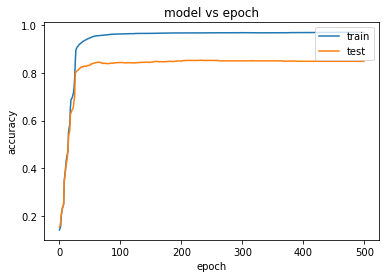

In [115]:
plt.plot(fusionLayer.history['accuracy'])
plt.plot(fusionLayer.history['val_accuracy'])
plt.title('model vs epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [116]:
loss, acc = fusionModel.evaluate([model.predict(x_testcnn),modelMel.predict(xmel_testcnn)], ymel_testcnn)
print("model, accuracy: {:5.2f}%".format(100*acc))

36/36 [==============================] - 0s 514us/step - loss: 0.4893 - accuracy: 0.8485
model, accuracy: 84.85%


In [117]:
test_predicts=fusionModel.predict([model.predict(x_testcnn),modelMel.predict(xmel_testcnn)]).round(1)
test_predicts

array([[0. , 0. , 0. , ..., 1. , 0. , 0. ],
       [1. , 0. , 0. , ..., 0. , 0. , 0. ],
       [1. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0.9, 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0.1, 0. , ..., 0.3, 0. , 0. ],
       [0. , 0. , 1. , ..., 0. , 0. , 0. ]], dtype=float32)

In [118]:
train_predicts=fusionModel.predict([model.predict(x_traincnn),modelMel.predict(xmel_traincnn)]).round(1)
train_predicts

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [ ]:
#modelMel.save('E:/testingFusion_model.h5')

In [119]:
all_predicts=fusionModel.predict([model.predict(x),modelMel.predict(x1)]).round(1)
all_predicts

array([[0. , 0. , 1. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 1. , 0. ],
       [0. , 0. , 1. , ..., 0. , 0. , 0. ],
       ...,
       [0.9, 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0.1, 0. , ..., 0.3, 0. , 0. ],
       [0. , 0. , 1. , ..., 0. , 0. , 0. ]], dtype=float32)

In [120]:
emotionsTypes=['neutral','happy','sad','angry','fear','digust','surprised']

In [121]:
emoList=[]
for i in range(0,4515):
    emoList.append(emotionsTypes[np.argmax(train_predicts,axis=1)[i]])
emoList=np.asarray(emoList)
emoList

array(['sad', 'digust', 'sad', ..., 'neutral', 'neutral', 'fear'],
      dtype='<U9')

In [122]:
from sklearn.manifold import TSNE
tsne = TSNE(learning_rate=200.0, n_iter=2000,perplexity=25.0)

In [123]:
#newdf_num=newdf.drop('label',axis=1) # My dataset with emotion label removed
#newdf.shape,newdf_num.shape 
tsne_features=tsne.fit_transform(all_predicts)
tsne_features.shape
tsne_features[:,0]

(5644, 2)

array([ 8.661195, 54.252823,  8.661195, ..., 58.81781 , 15.447669,
        7.278051], dtype=float32)

<AxesSubplot:>

<function matplotlib.pyplot.show(close=None, block=None)>

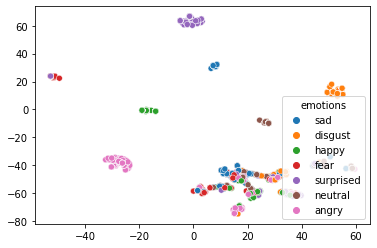

In [124]:
sns.scatterplot(x=tsne_features[:,0],y=tsne_features[:,1],hue=y,data=all_predicts)
plt.show